# Linear Regression

## Sequential Bayesian Learning (Figure 3.7)

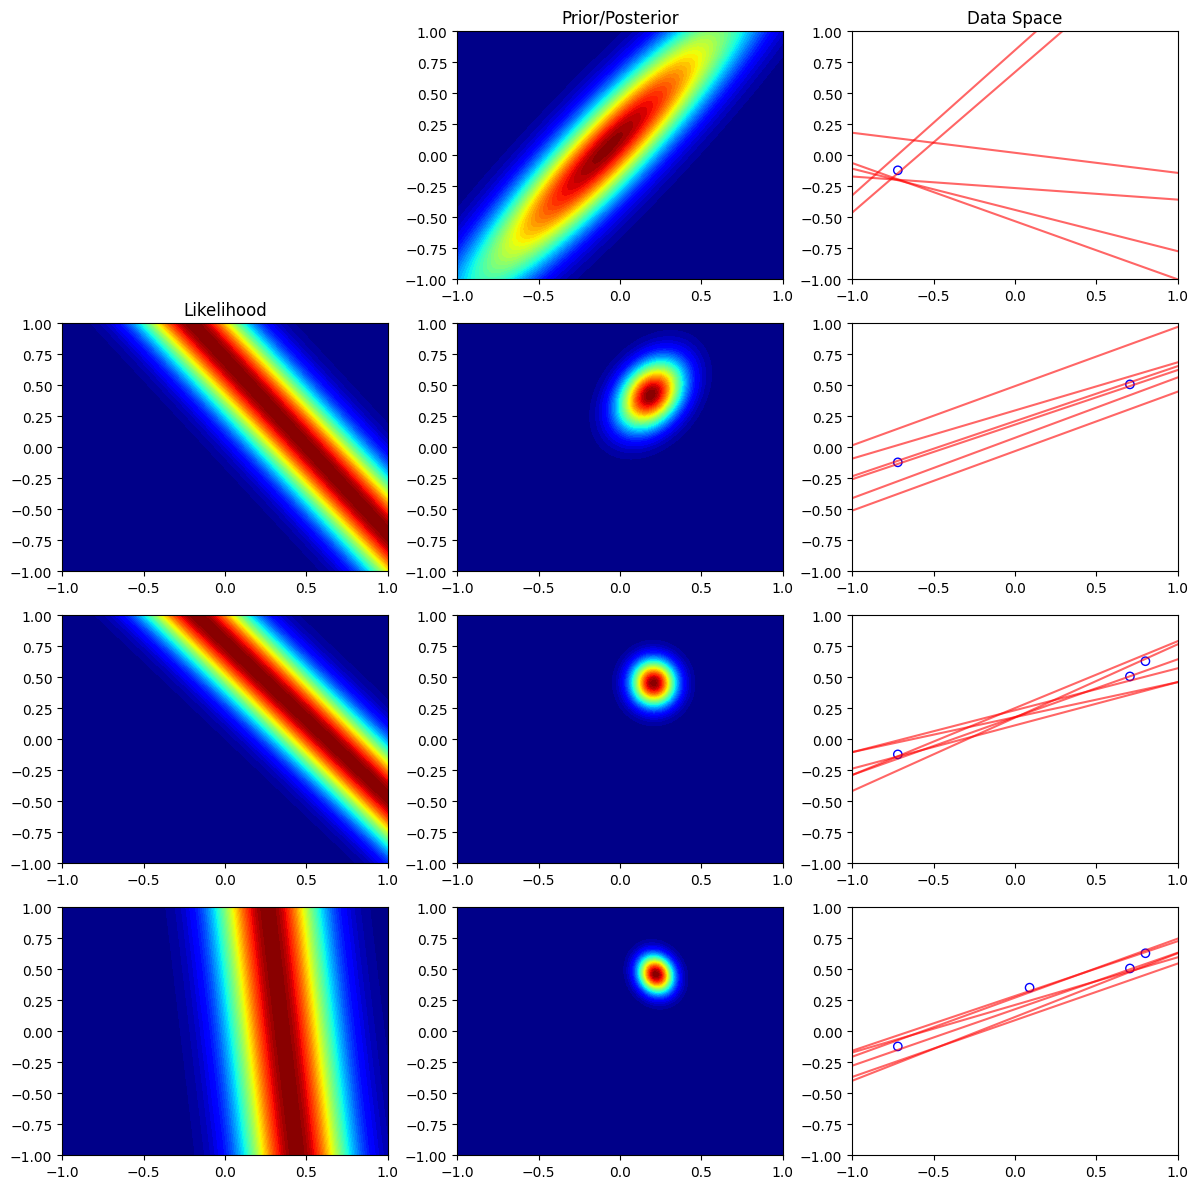

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import multivariate_normal


# Bayesian update function
def bayesian_update(prior_mean, prior_cov, x, y, noise_var):
    X = np.vstack([np.ones_like(x), x]).T
    precision_prior = np.linalg.inv(prior_cov)
    precision_likelihood = (1 / noise_var) * X.T @ X
    cov_posterior = np.linalg.inv(precision_prior + precision_likelihood)
    mean_posterior = cov_posterior @ (precision_prior @ prior_mean + (1 / noise_var) * X.T @ y)
    return mean_posterior, cov_posterior

# Synthetic data
def generate_data(n, noise_std=0.1):
    x = np.random.uniform(-1, 1, n)
    y = 0.3 + 0.5 * x + np.random.normal(0, noise_std, n)
    return x, y

# Parameters
n_rows = 4
noise_var = 0.05
prior_mean = np.array([0.0, 0.0])
prior_cov = np.eye(2)
x_vec = np.linspace(-1, 1, 100)

# Prepare figure
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(n_rows, 3, figure=fig)

mean = prior_mean
cov = prior_cov
x_all, y_all = [], []

for i in range(n_rows):
    x_new, y_new = generate_data(1)
    x_all.append(x_new[0])
    y_all.append(y_new[0])

    # Column 1: Likelihood
    if i > 0:
        w0, w1 = np.meshgrid(x_vec, x_vec)
        likelihood = np.exp(-((y_new[0] - (w0 + w1 * x_new[0]))**2) / (2 * noise_var))
        ax = fig.add_subplot(gs[i, 0])
        ax.contourf(w0, w1, likelihood, levels=50, cmap='jet')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        if i == 1:
            ax.set_title("Likelihood")

    # Column 2: Posterior
    mean, cov = bayesian_update(mean, cov, np.array(x_all), np.array(y_all), noise_var)
    w0, w1 = np.meshgrid(x_vec, x_vec)
    pos = np.dstack((w0, w1))
    posterior = multivariate_normal(mean, cov).pdf(pos)
    ax = fig.add_subplot(gs[i, 1])
    ax.contourf(w0, w1, posterior, levels=50, cmap='jet')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    if i == 0:
        ax.set_title("Prior/Posterior")

    # Column 3: Data Space
    ax = fig.add_subplot(gs[i, 2])
    for _ in range(6):
        w_sample = np.random.multivariate_normal(mean, cov)
        x_line = np.linspace(-1, 1, 100)
        y_line = w_sample[0] + w_sample[1] * x_line
        ax.plot(x_line, y_line, 'r-', alpha=0.6)
    ax.scatter(x_all, y_all, facecolors='none', edgecolors='b')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    if i == 0:
        ax.set_title("Data Space")

plt.tight_layout()
plt.show()


## Predictive Distribution with Gaussian Basis Functions (Figure 3.8)

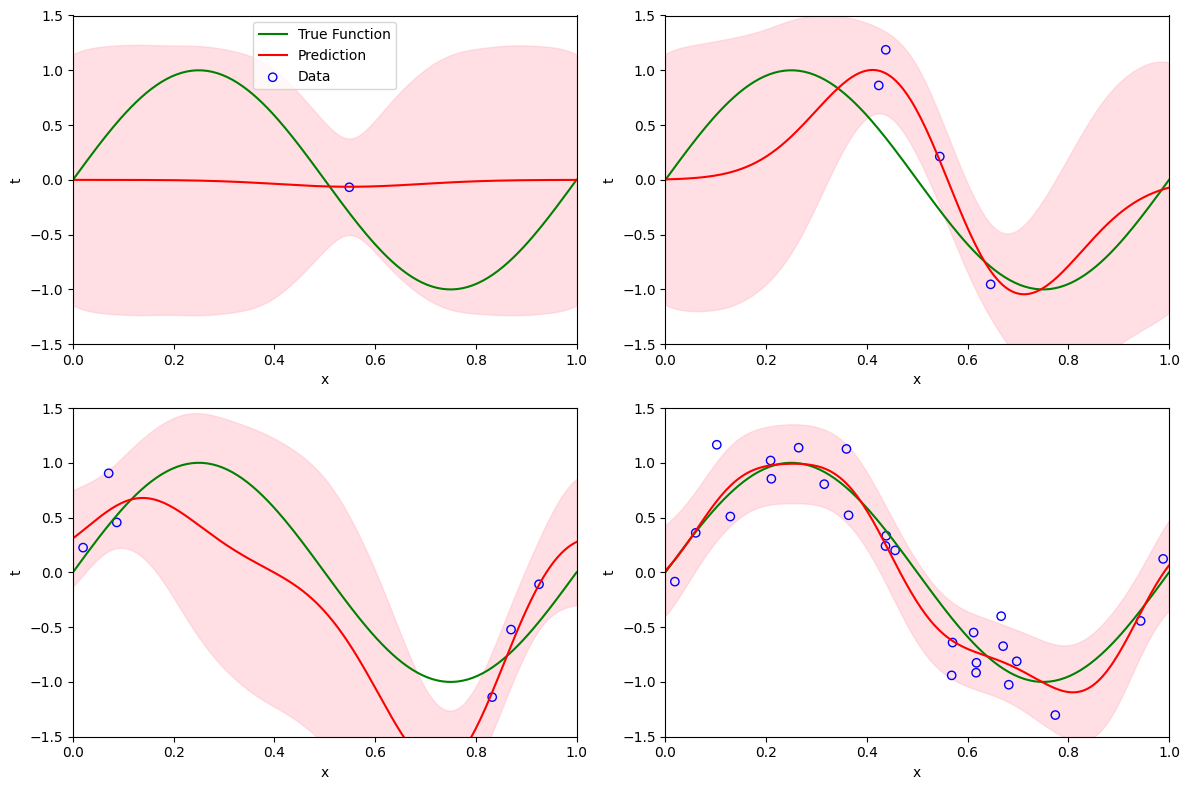

In [ ]:
from numpy.linalg import inv

# True function
def true_function(x):
    return np.sin(2 * np.pi * x)

# Gaussian basis functions
def design_matrix(x, centers, width):
    return np.exp(-0.5 * ((x[:, None] - centers[None, :]) / width)**2)

# Settings
num_basis = 9
centers = np.linspace(0, 1, num_basis)
width = 0.1
beta_inv = 0.1
alpha = 1.0
x_test = np.linspace(0, 1, 200)
phi_test = design_matrix(x_test, centers, width)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
data_sizes = [1, 4, 7, 25]
np.random.seed(0)

for i, N in enumerate(data_sizes):
    x_train = np.random.rand(N)
    y_train = true_function(x_train) + np.random.normal(0, np.sqrt(beta_inv), N)
    phi_train = design_matrix(x_train, centers, width)

    S_N_inv = alpha * np.eye(num_basis) + (1 / beta_inv) * phi_train.T @ phi_train
    S_N = inv(S_N_inv)
    m_N = (1 / beta_inv) * S_N @ phi_train.T @ y_train

    mean_pred = phi_test @ m_N
    var_pred = np.sum(phi_test @ S_N * phi_test, axis=1) + beta_inv
    std_pred = np.sqrt(var_pred)

    ax = axs[i // 2, i % 2]
    ax.plot(x_test, true_function(x_test), 'g', label='True Function')
    ax.plot(x_test, mean_pred, 'r', label='Prediction')
    ax.fill_between(x_test, mean_pred - std_pred, mean_pred + std_pred, color='pink', alpha=0.5)
    ax.scatter(x_train, y_train, facecolors='none', edgecolors='b', label='Data')
    ax.set_xlim(0, 1)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


# Stretch Goal - Evidence Approximation

In [3]:
import numpy as np
from numpy.linalg import inv, eigvalsh

# Define true function and basis expansion
def true_function(x):
    return np.sin(2 * np.pi * x)

def design_matrix(x, centers, width):
    return np.exp(-0.5 * ((x[:, None] - centers[None, :]) / width)**2)

# Setup
num_basis = 9
centers = np.linspace(0, 1, num_basis)
width = 0.1
N = 25
x_train = np.random.rand(N)
t_train = true_function(x_train) + np.random.normal(0, 0.3, N)
phi = design_matrix(x_train, centers, width)

# Initialize alpha and beta
alpha = 1.0
beta = 1.0 / 0.09
tolerance = 1e-4
max_iter = 100

for i in range(max_iter):
    S_N_inv = alpha * np.eye(num_basis) + beta * phi.T @ phi
    S_N = inv(S_N_inv)
    m_N = beta * S_N @ phi.T @ t_train

    # gamma = sum of eigenvalues of beta * phi.T @ phi / (alpha + eigenvalue)
    eigvals = eigvalsh(beta * phi.T @ phi)
    gamma = np.sum(eigvals / (alpha + eigvals))

    # Update alpha and beta
    alpha_new = gamma / np.dot(m_N, m_N)
    residual = t_train - phi @ m_N
    beta_inv_new = (np.sum(residual ** 2)) / (N - gamma)
    beta_new = 1.0 / beta_inv_new

    if np.abs(alpha_new - alpha) < tolerance and np.abs(beta_new - beta) < tolerance:
        break

    alpha, beta = alpha_new, beta_new

print(f"Estimated alpha: {alpha:.4f}")
print(f"Estimated beta: {beta:.4f}")
print(f"Effective number of parameters (gamma): {gamma:.4f}")
print(f"Converged in {i+1} iterations.")


Estimated alpha: 4.7388
Estimated beta: 7.2854
Effective number of parameters (gamma): 5.4989
Converged in 4 iterations.
